# Word2Vec Model Creation

## Montando carpeta de google drive (opcional)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
import os
folder_path = "/content/gdrive/MyDrive/NLP - 2024-2/hw04"
os.chdir(folder_path)

## Cargando los libros

Escogimos los tres libros más populares (con más descargas) de [Project Gutenberg](https://www.gutenberg.org/) de los siguientes autores en inglés:

- **Jane Austen**:
  - Emma
  - Pride and Prejudice
  - Sense and Sensibility
- **Edgar Allan Poe**:
  - The Works of Edgar Allan Poe Volume 1
  - The Works of Edgar Allan Poe Volume 2
  - The Fall of the House of Usher
- **Arthur Conan Doyle**:
  - A Study in Scarlet
  - The Adventures of Sherlock Holmes
  - The Hound of the Baskervilles

In [3]:
import re, os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from typing import List, Optional, Union
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def extract_text_between_markers(file_content: str) -> Optional[str]:
    """
    Extrae el contenido de un libro entre los marcadores de inicio y fin de Project Gutenberg.

    Args:
        file_content (str): El contenido completo sin procesar del archivo de texto del libro.

    Returns:
        Optional[str]: El contenido del libro entre los marcadores o None si no se encuentran los marcadores.
    """
    start_marker = r"\*\*\* START OF THE PROJECT GUTENBERG EBOOK"
    end_marker = r"\*\*\* END OF THE PROJECT GUTENBERG EBOOK"

    # Busca las posiciones de los marcadores de inicio y fin
    start_idx = re.search(start_marker, file_content)
    end_idx = re.search(end_marker, file_content)

    # Si ambos marcadores están presentes, devuelve el texto entre ellos
    if start_idx and end_idx:
        return file_content[start_idx.end():end_idx.start()]

    # Si no se encuentran los marcadores, devuelve None
    return None

def preprocess_text(text: str) -> List[str]:
    """
    Preprocesa el texto para eliminar puntuación, stopwords, y lematiza las palabras.

    Args:
        text (str): El texto a preprocesar.

    Returns:
        List[str]: Lista de tokens (palabras) preprocesados.
    """
    # Convierte el texto a minúsculas
    text = text.lower()

    # Elimina la puntuación, dejando solo letras, números y espacios
    text = re.sub(r'[^\w\s]', '', text)

    # Divide el texto en palabras (tokens) por espacios
    tokens = text.split()

    # Elimina stopwords y palabras con menos de 3 caracteres
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Lematiza los tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

def load_books_from_directory(directory: str) -> List[List[str]]:
    """
    Carga y preprocesa los textos de libros desde un directorio organizado por autores. Se asume que cada subcarpeta
    es un autor, y dentro de cada uno de estas están los libros en formato txt.

    Args:
        directory (str): El directorio que contiene subdirectorios con los libros de cada autor.

    Returns:
        List[List[str]]: Una lista de listas, donde cada lista interna contiene los tokens preprocesados de un libro.
    """
    all_books = []  # Lista para almacenar todos los libros preprocesados

    # Itera sobre cada autor en el directorio
    for author in os.listdir(directory):
        author_path = os.path.join(directory, author)

        if os.path.isdir(author_path):
            for book_file in os.listdir(author_path):
                # Solo procesar archivos de texto
                if book_file.endswith('.txt'):
                    book_path = os.path.join(author_path, book_file)

                    # Abre el archivo de texto y lee su contenido
                    with open(book_path, 'r', encoding='utf-8') as f:
                        file_content = f.read()

                    # Extrae el texto entre los marcadores del archivo
                    extracted_text = extract_text_between_markers(file_content)

                    # Si el texto fue extraído correctamente, preprocesa el contenido
                    if extracted_text:
                        tokens = preprocess_text(extracted_text)
                        all_books.append(tokens)

    return all_books

books_directory = 'books'
preprocessed_books = load_books_from_directory(books_directory)

Un ejemplo de las últimas 20 palabras del primer libro extraído:

In [5]:
preprocessed_books[0][-20:]

['violet',
 'hunter',
 'friend',
 'holmes',
 'rather',
 'disappointment',
 'manifested',
 'interest',
 'ceased',
 'centre',
 'one',
 'problem',
 'head',
 'private',
 'school',
 'walsall',
 'believe',
 'met',
 'considerable',
 'success']

## Gensim training

In [6]:
def train_word2vec(books: List[List[str]], embedding_sizes: List[int] = [100, 200, 300], save_dir: str = 'models') -> None:
    """
    Entrena Word2Vec con diferentes tamaños de embeddings y los guarda en el directorio indicado.

    Args:
        books (List[List[str]]): Lista de libros, donde cada libro es una lista de tokens preprocesados (palabras).
        embedding_sizes (List[int], opcional): Lista de tamaños de embeddings a utilizar para entrenar diferentes modelos. Por defecto es [100, 200, 300].
        save_dir (str, opcional): Directorio donde se guardarán los modelos entrenados. Por defecto es 'models'.

    Returns:
        None: Solo guarda los modelos entrenados en archivos.
    """
    # Crea el directorio de guardado si no existe
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Itera sobre los tamaños de embeddings especificados
    for size in embedding_sizes:
        print(f"Entrenando modelo Word2Vec de tamaño {size}...")

        # Entrena el modelo Word2Vec
        model = Word2Vec(
            sentences=books,   # La lista de tokens que contiene los textos preprocesados de los libros
            vector_size=size,  # Tamaño de los embeddings
            window=5,          # Tamaño de la ventana de contexto
            min_count=1,       # Mínimo de veces que una palabra debe aparecer para ser considerada
            sg=1,              # Skipgram (1) o CBOW (0)
            workers=4,         # Número de hilos para el entrenamiento
            epochs=10          # Número de épocas para entrenar el modelo
        )

        # Define el nombre del archivo para guardar el modelo
        model_filename = f"Books_{size}.model"
        # Guarda el modelo entrenado
        model.save(os.path.join(save_dir, model_filename))
        print(f"Modelo de tamaño {size} guardado como {model_filename}")

In [7]:
embedding_sizes = [100, 200, 300]
train_word2vec(preprocessed_books, embedding_sizes)

Entrenando modelo Word2Vec de tamaño 100...
Modelo de tamaño 100 guardado como Books_100.model
Entrenando modelo Word2Vec de tamaño 200...
Modelo de tamaño 200 guardado como Books_200.model
Entrenando modelo Word2Vec de tamaño 300...
Modelo de tamaño 300 guardado como Books_300.model


## Embeddings visualization

In [12]:
def plot_embeddings_2d(models: list, main_word: str, num_similar: int = 10, reduction_method: str = 'tsne') -> None:
    """
    Grafica los embeddings en 2 dimensiones para tres modelos diferentes utilizando un método de reducción de dimensionalidad (PCA o t-SNE).
    Busca las palabras más similares a la palabra principal y las muestra en tres gráficos dispuestos horizontalmente.

    Args:
        models (list): Una lista con tres modelos Word2Vec entrenados que contienen los embeddings.
        main_word (str): La palabra principal para la cual se graficarán los embeddings.
        num_similar (int, opcional): Número de palabras similares a mostrar en el gráfico. Por defecto es 10.
        reduction_method (str, opcional): Método de reducción de dimensionalidad a utilizar ('pca' o 'tsne'). Por defecto es 'tsne'.

    Returns:
        None: Solo muestra gráficos de los embeddings.
    """
    if len(models) != 3:
        raise ValueError("Debe proporcionar exactamente tres modelos Word2Vec.")

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    for idx, model in enumerate(models):
        # Obtiene las palabras más similares a main_word
        similar_words = model.wv.most_similar(main_word, topn=num_similar)

        # Lista de palabra total
        words = [main_word] + [word for word, _ in similar_words]

        # Obtiene los vectores de los embeddings para cada palabra
        word_vectors = np.array([model.wv[word] for word in words])

        # Reducción de dimensionalidad con el método seleccionado (PCA o t-SNE)
        if reduction_method == 'pca':
            pca = PCA(n_components=2)
            word_vectors_2d = pca.fit_transform(word_vectors)
        elif reduction_method == 'tsne':
            tsne = TSNE(n_components=2, perplexity=5, random_state=0)
            word_vectors_2d = tsne.fit_transform(word_vectors)
        else:
            raise ValueError(f"Método de reducción {reduction_method} no soportado. Use 'pca' o 'tsne'.")

        # Grafica los embeddings como puntos en 2D
        axes[idx].scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1])
        for i, word in enumerate(words):
            axes[idx].annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=10)

        vector_size = model.wv.vector_size
        axes[idx].set_title(f'Embeddings ({vector_size}-dim) para "{main_word}"')
        axes[idx].grid(True)

    plt.tight_layout()
    plt.show()

Para los libros con un personaje principal, usaremos esta función para observar en 2D sus palabras más similares dados los modelos entrenados.

In [10]:
models = [Word2Vec.load(f"models/Books_{size}.model") for size in [100,200,300]]

### Jane Austen - Emma

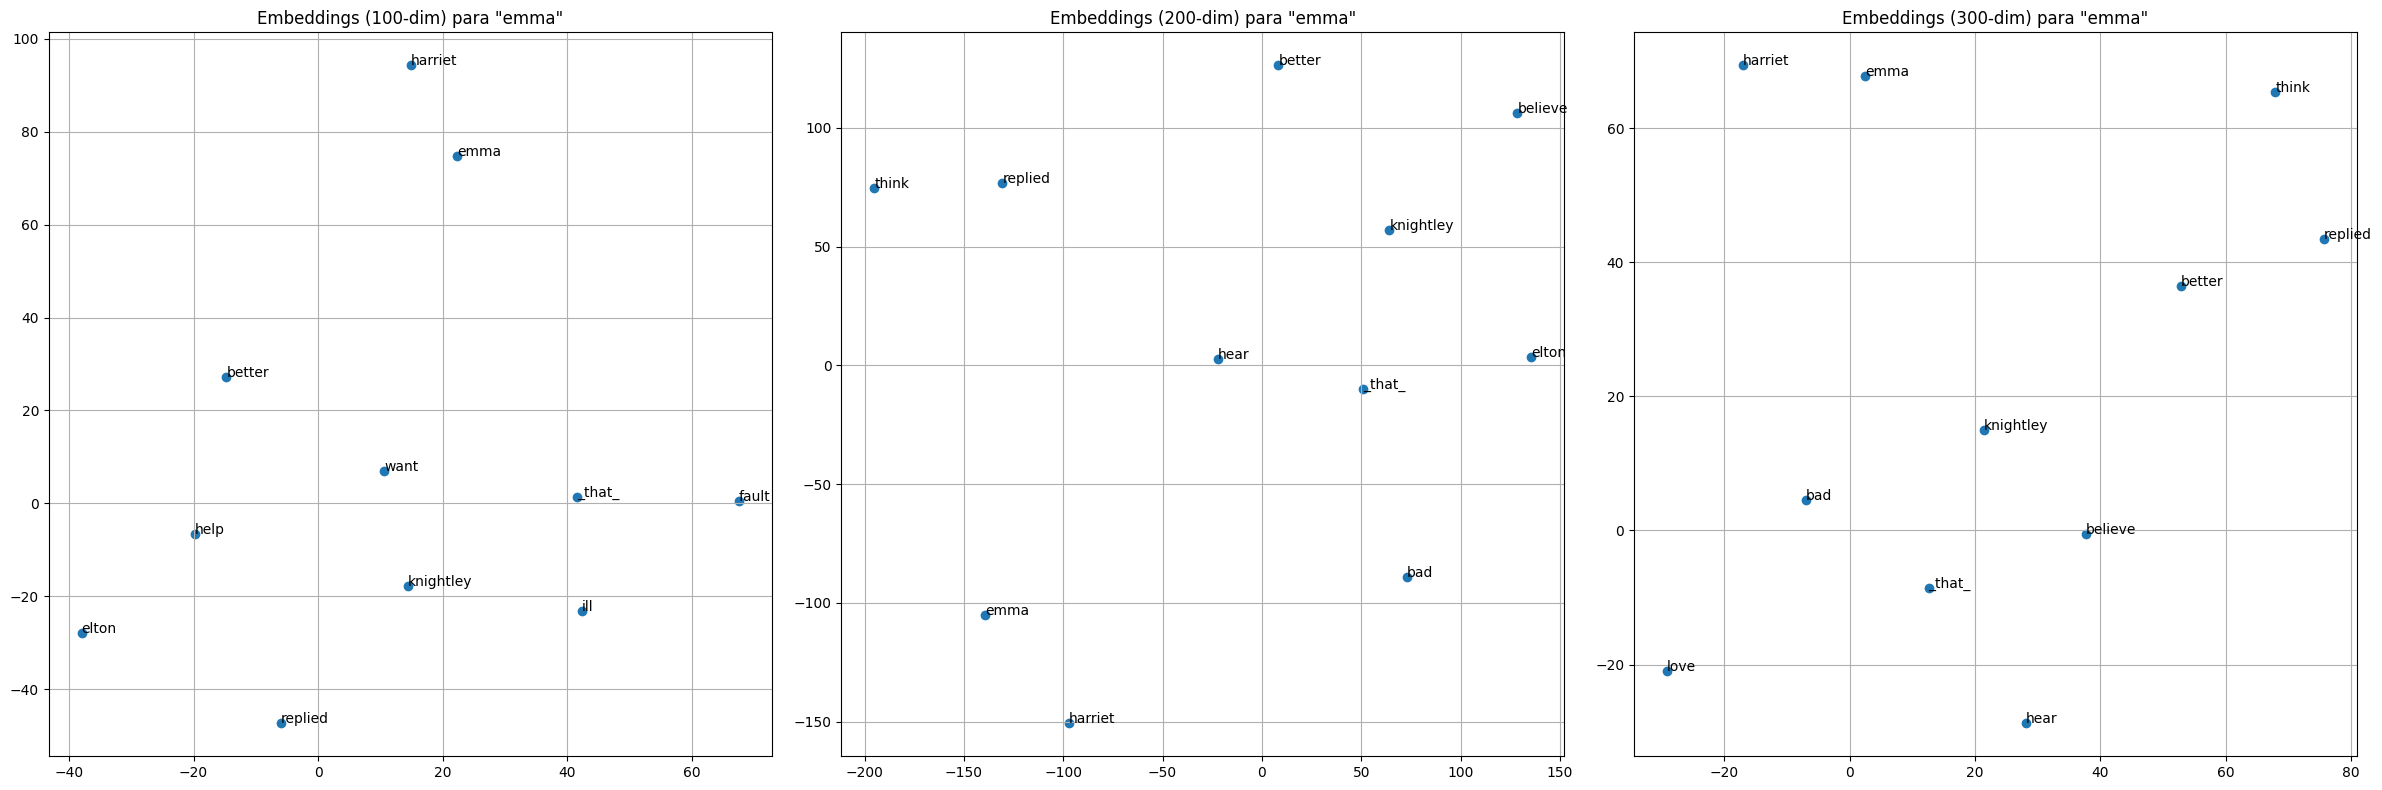

In [17]:
plot_embeddings_2d(models, 'emma', num_similar=10, reduction_method='tsne')

### Jane Austen - Pride and Prejudice

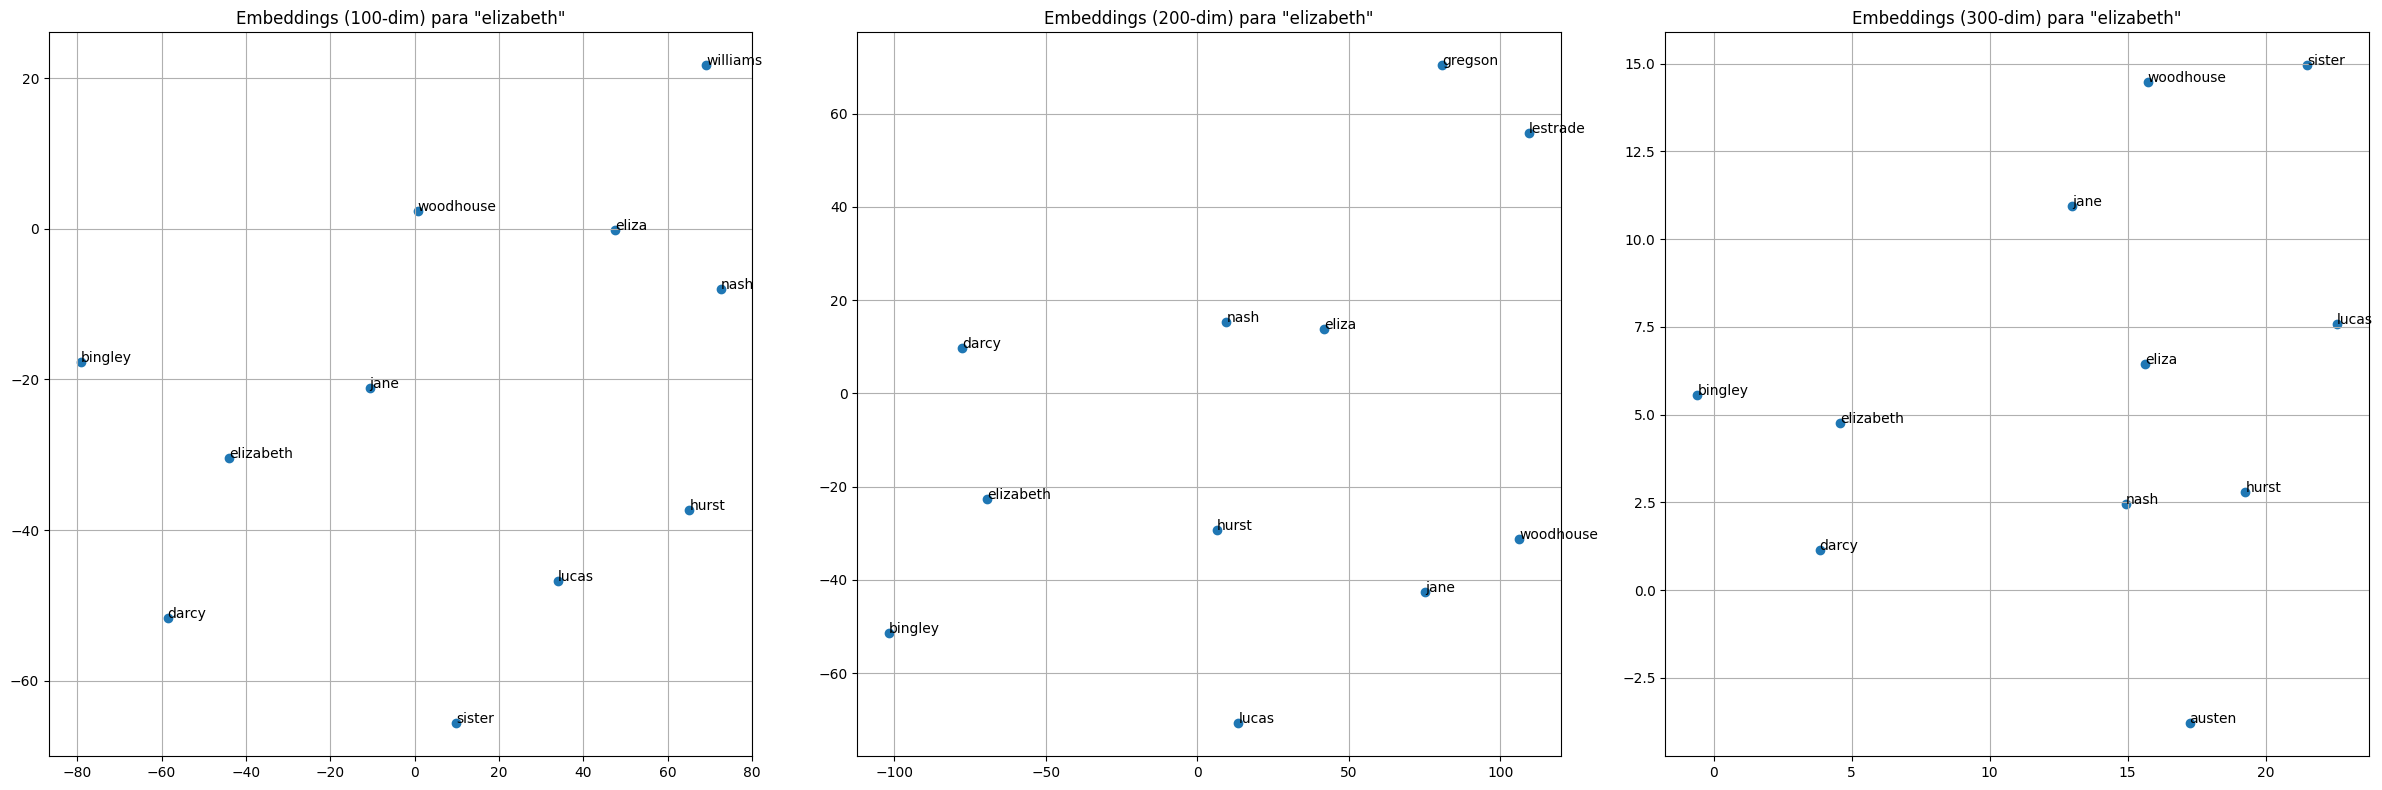

In [18]:
plot_embeddings_2d(models, 'elizabeth', num_similar=10, reduction_method='tsne')

### Jane Austen - Sense and Sensibility

Sigue la vida de las tres hermanas Dashwood, pero se centra en Elinor y Marianne.

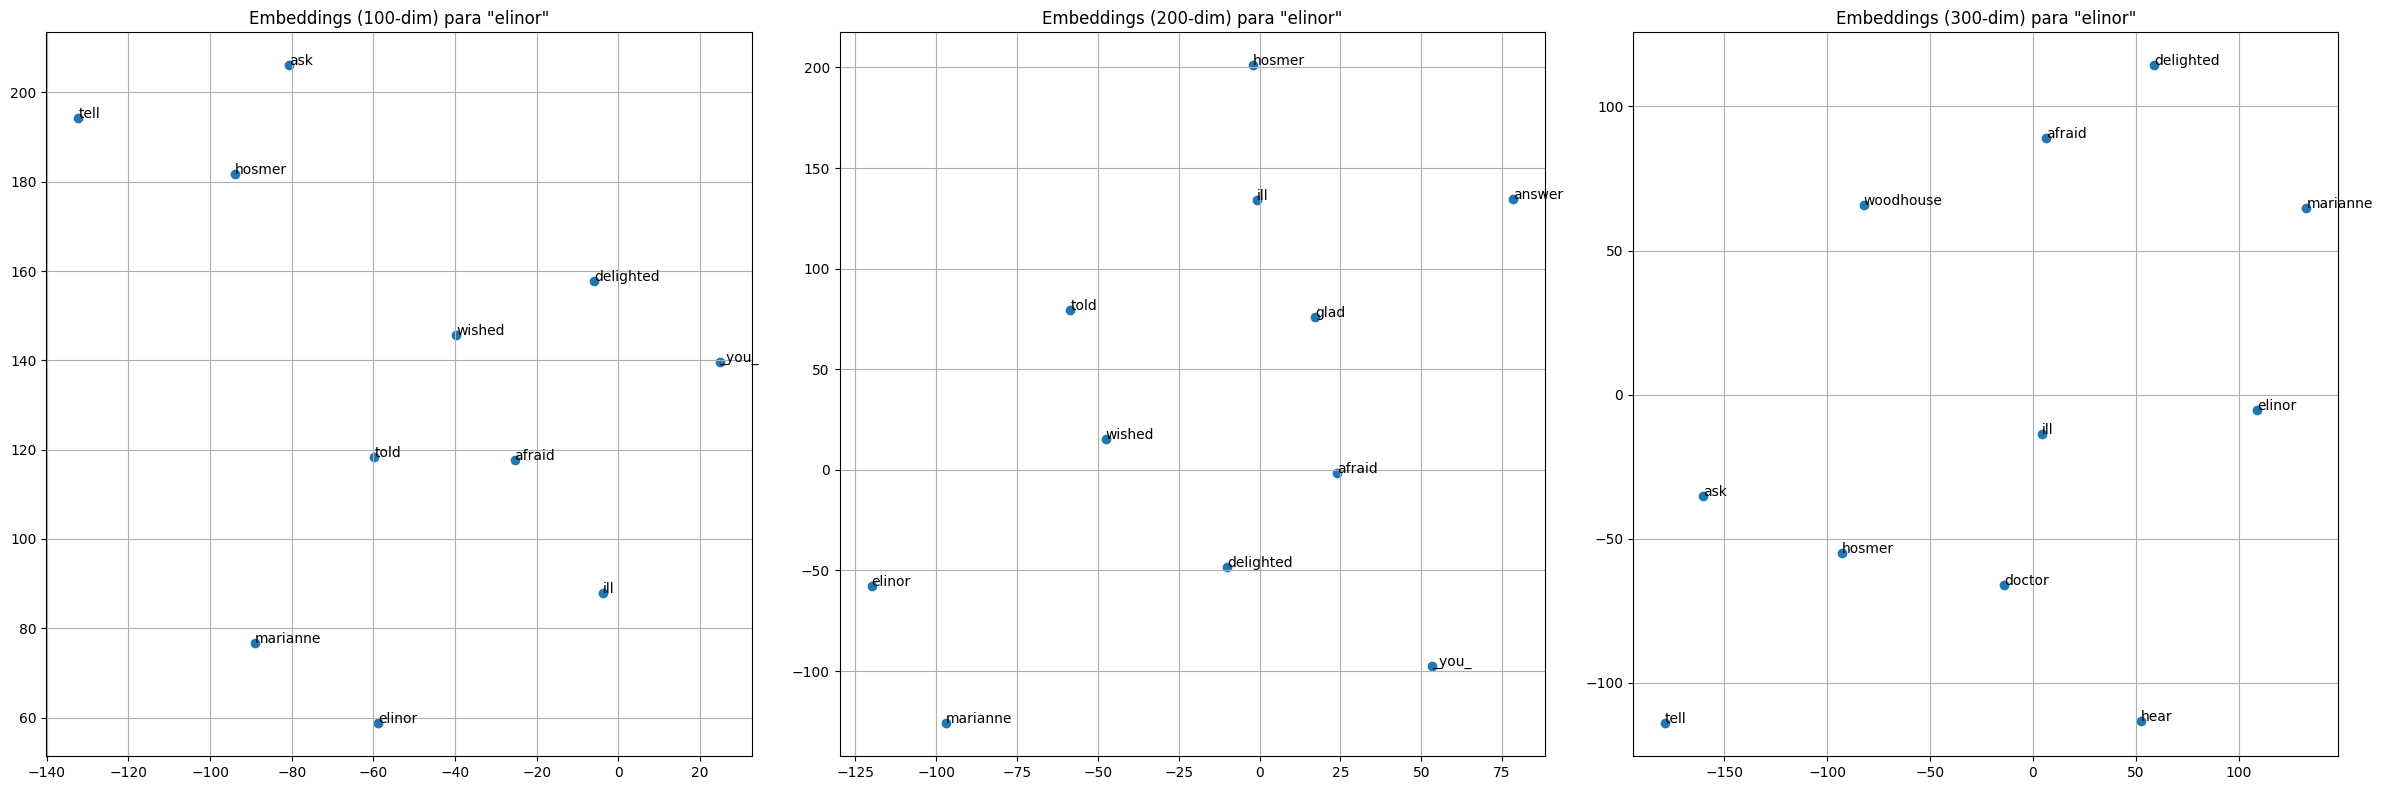

In [19]:
plot_embeddings_2d(models, 'elinor', num_similar=10, reduction_method='tsne')

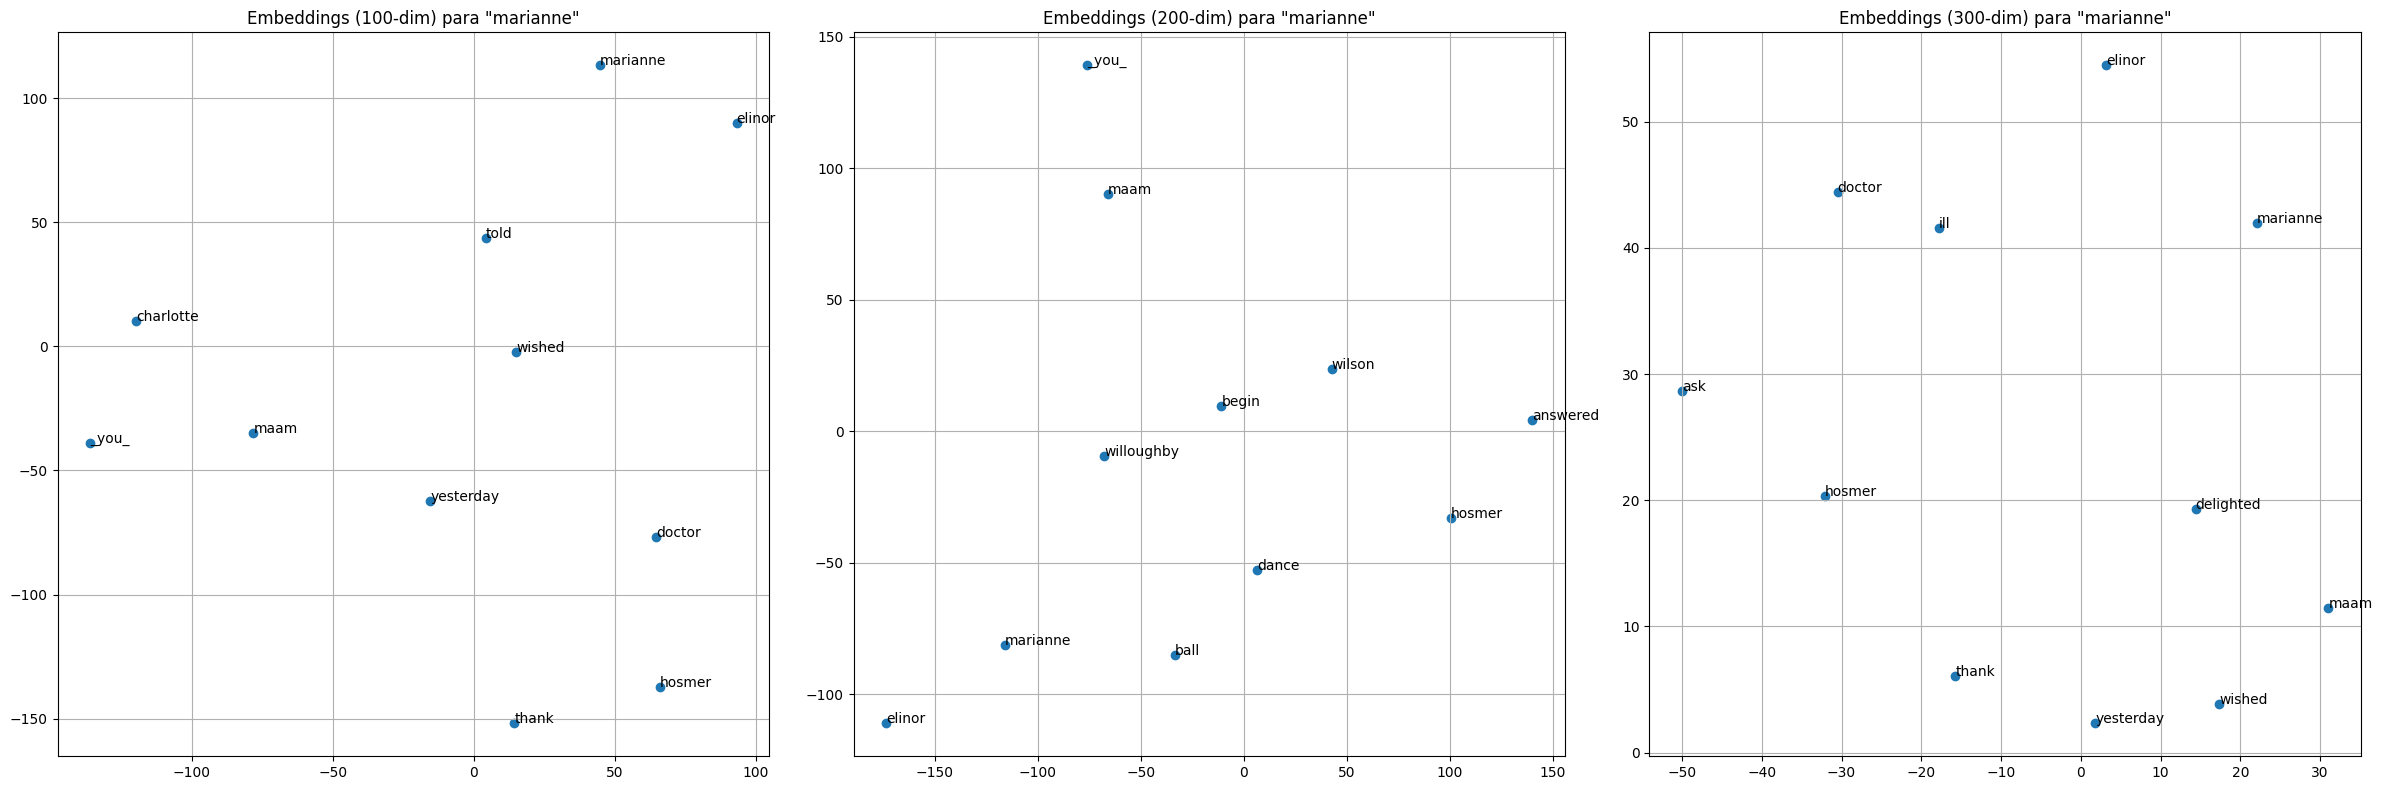

In [20]:
plot_embeddings_2d(models, 'marianne', num_similar=10, reduction_method='tsne')

### Edgar Allan Poe - The Fall of the House of Usher

El protagonista no tiene nombre, pero podemos usar el de su amigo de la infancia, Roderick Usher.

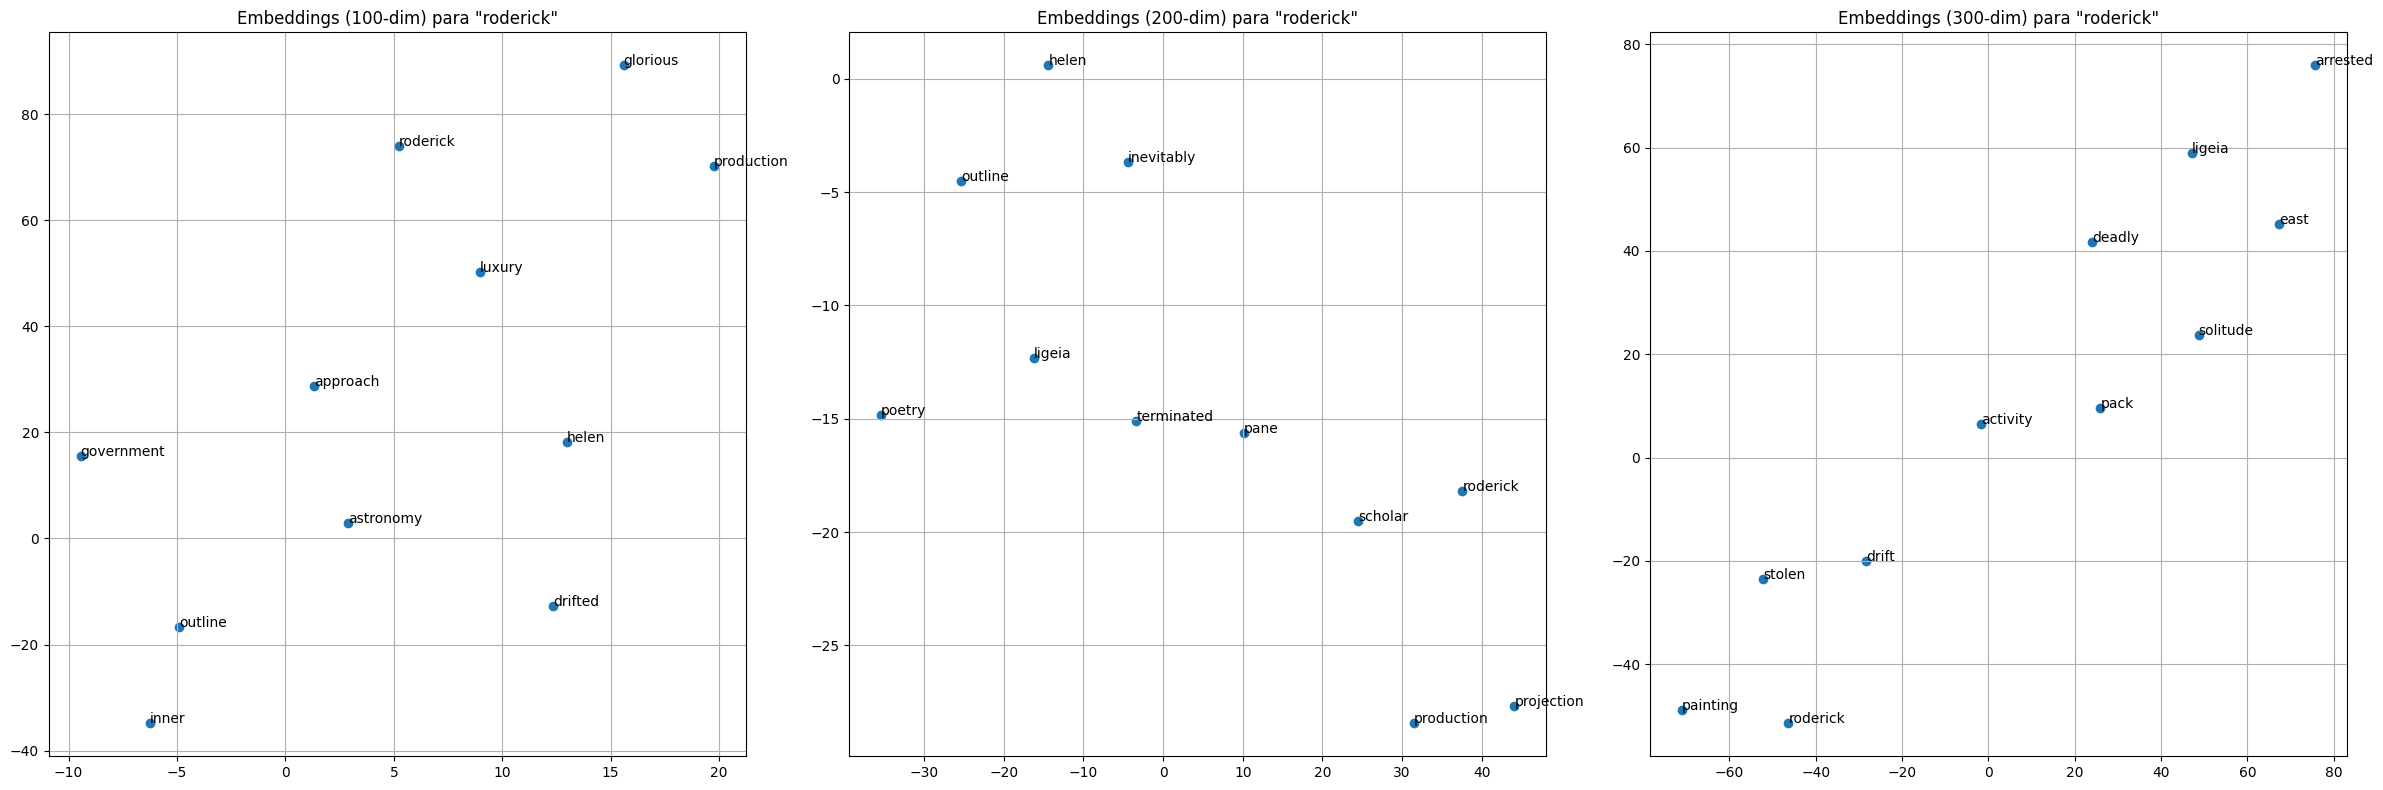

In [21]:
plot_embeddings_2d(models, 'roderick', num_similar=10, reduction_method='tsne')

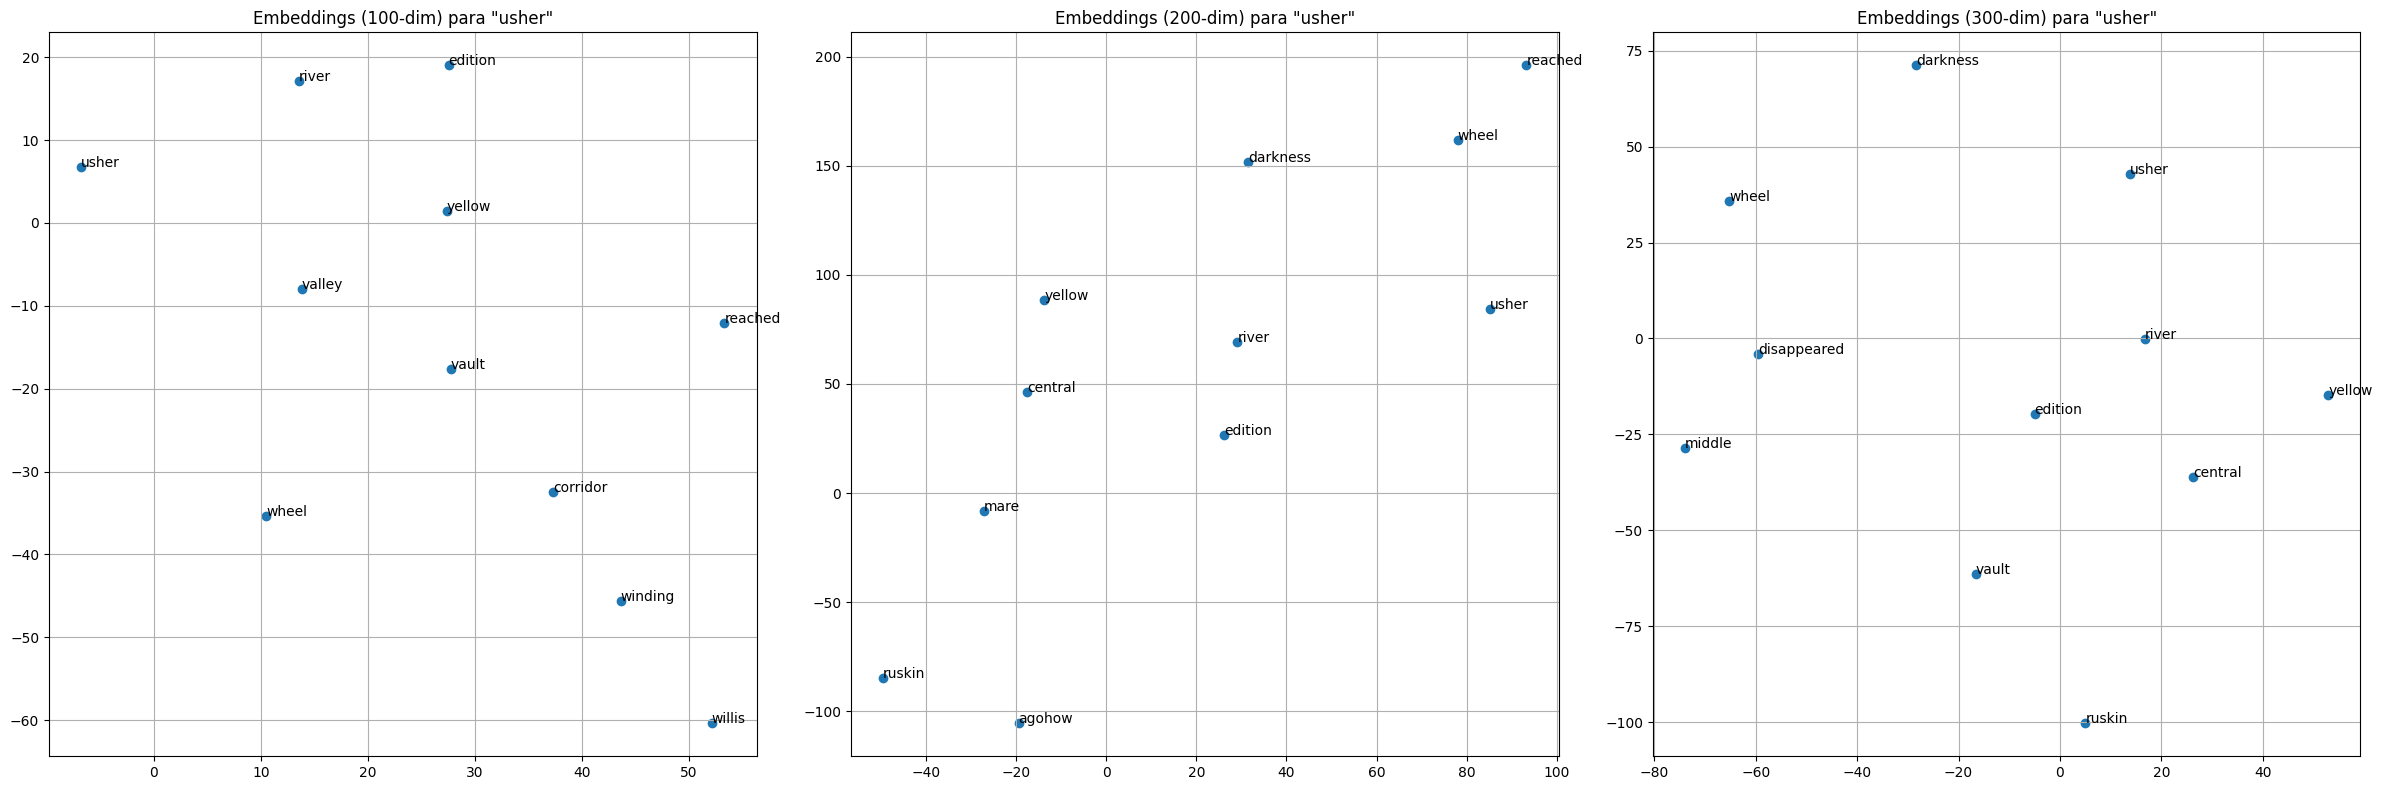

In [22]:
plot_embeddings_2d(models, 'usher', num_similar=10, reduction_method='tsne')

### Arthur Conan Doyle

Todos los libros recuperados de Arthur Conan Doyle son sobre Sherlock Holmes. Usaremos a este, junto con Watson.

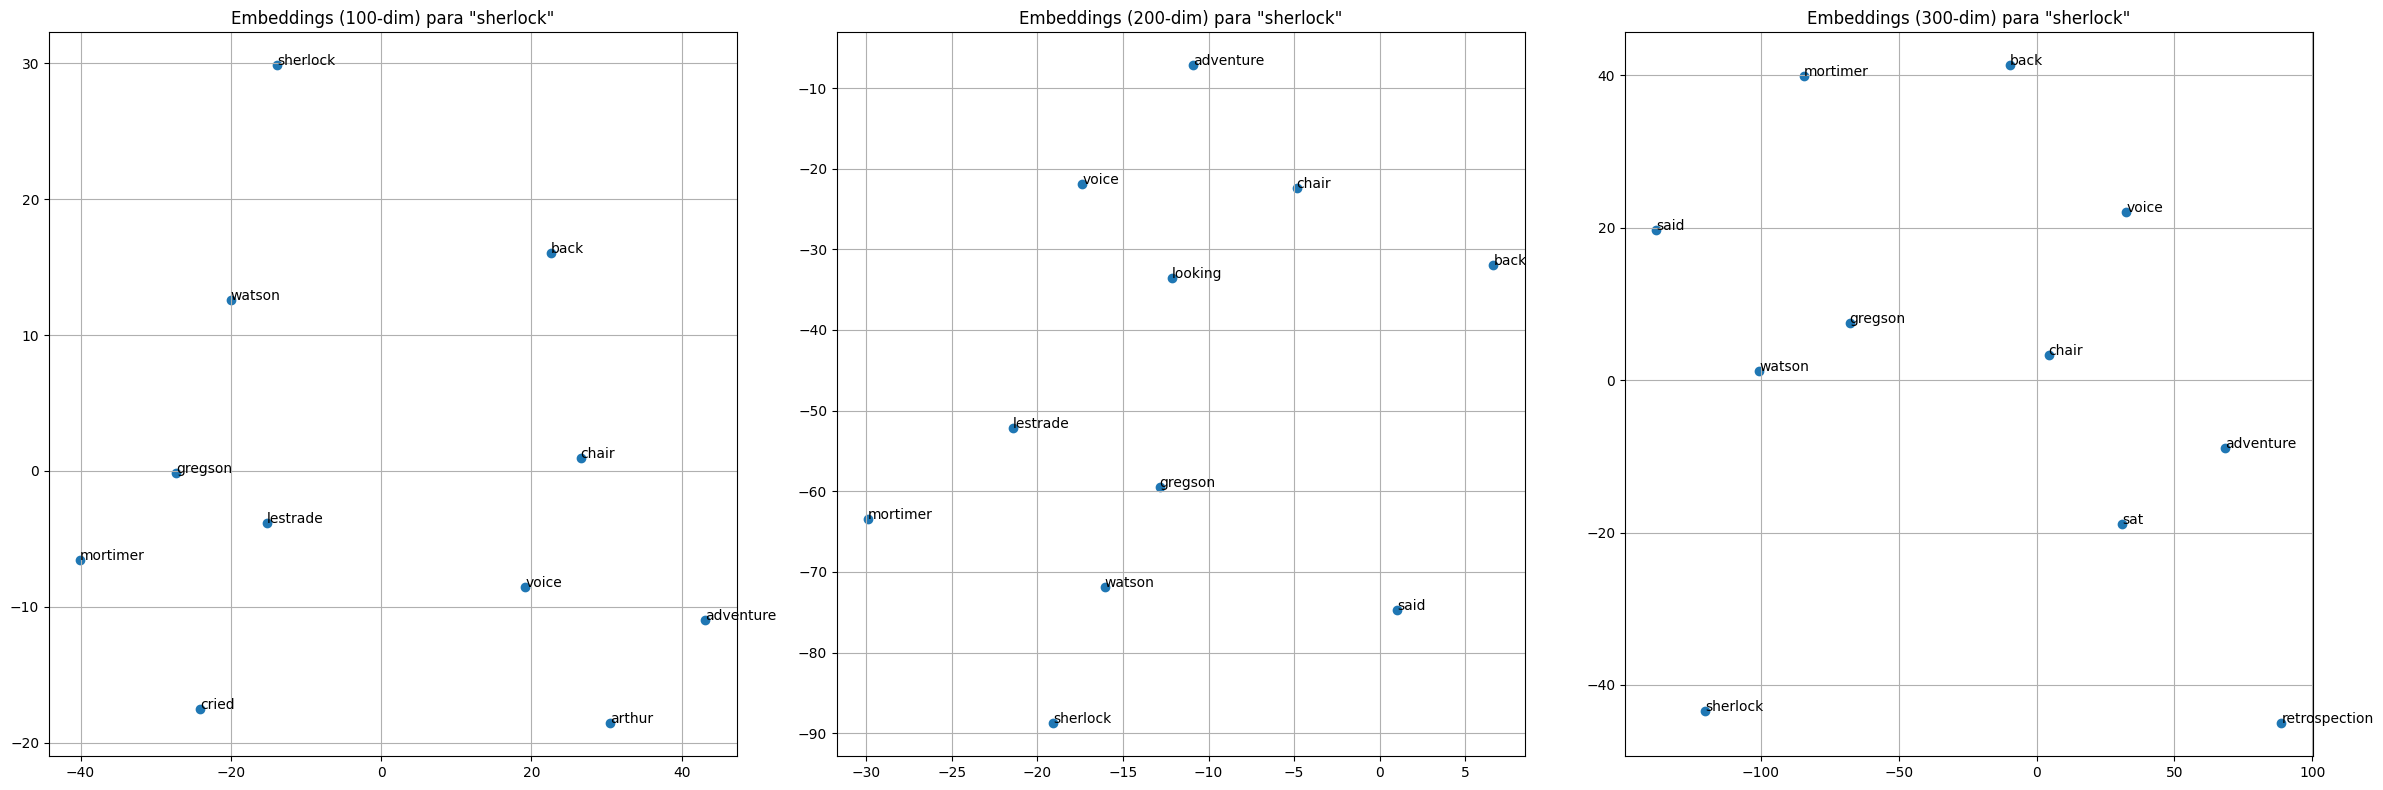

In [23]:
plot_embeddings_2d(models, 'sherlock', num_similar=10, reduction_method='tsne')

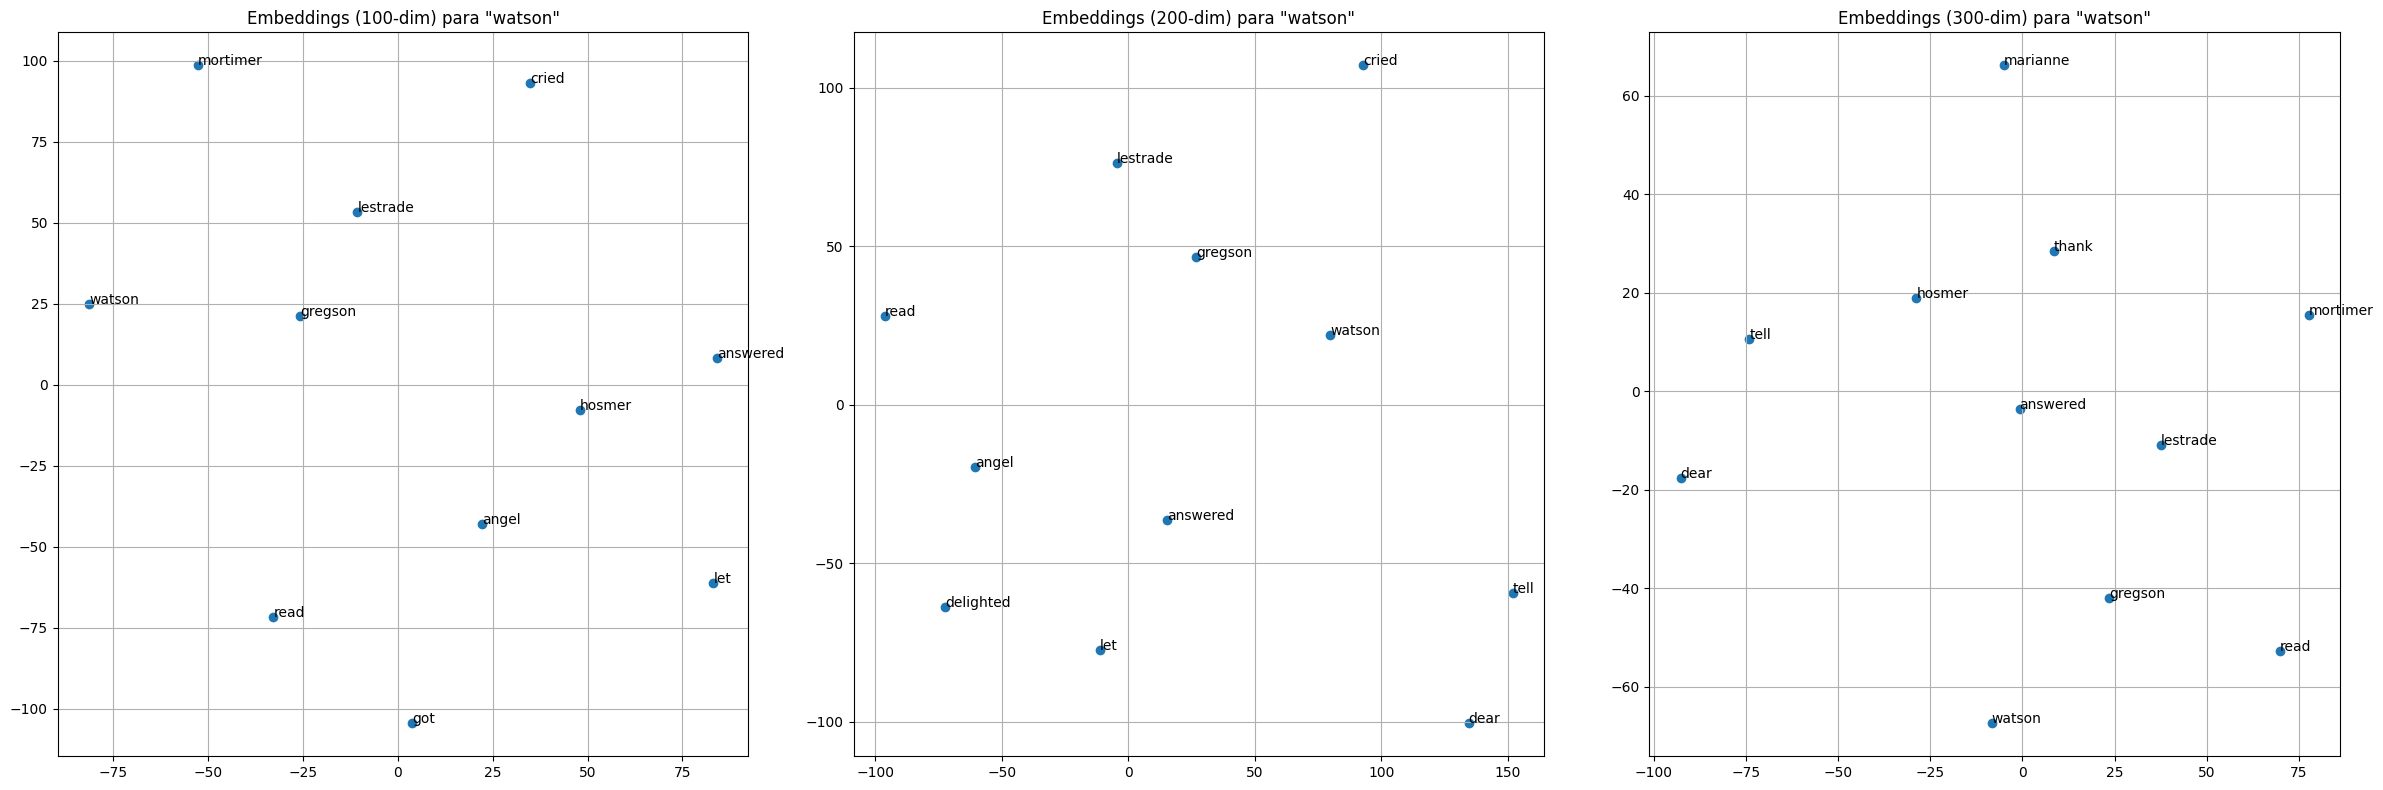

In [24]:
plot_embeddings_2d(models, 'watson', num_similar=10, reduction_method='tsne')

En casos donde un libro no tenga un personaje principal, por ejemplo algunas obras de Edgar Allan Poe, podemos identificar palabras claves usando TF-IDF y buscar las más similares a estas.

In [25]:
def load_and_preprocess_book(directory: str, author: str, book: str) -> Optional[str]:
    """
    Carga y preprocesa un libro específico de un autor, extrayendo el texto y devolviendo
    los tokens preprocesados como una cadena.

    Args:
        directory (str): El directorio raíz que contiene los subdirectorios de los autores.
        author (str): El nombre del autor (subdirectorio).
        book (str): El nombre del archivo de texto del libro.

    Returns:
        Optional[str]: Una cadena con el texto preprocesado del libro o None si no se pudo procesar.
    """
    # Construye la ruta al directorio del autor y al archivo del libro
    author_path = os.path.join(directory, author)
    book_path = os.path.join(author_path, book)

    # Verifica si el archivo del libro existe
    if os.path.isfile(book_path):
        # Abre el archivo del libro y lee su contenido
        with open(book_path, 'r', encoding='utf-8') as f:
            file_content = f.read()

        # Extrae el texto entre los marcadores de Project Gutenberg
        extracted_text = extract_text_between_markers(file_content)

        # Si el texto fue extraído correctamente, lo preprocesa y devuelve los tokens como una cadena
        if extracted_text:
            tokens = preprocess_text(extracted_text)
            return " ".join(tokens)

    # Si el archivo no existe o no se pudo procesar, devuelve None
    return None

In [27]:
def extract_top_keywords_from_book(book_text: str, num_keywords: int = 15) -> List[str]:
    """
    Extrae las principales palabras clave de un texto de libro utilizando TF-IDF.

    Args:
        book_text (str): Texto preprocesado del libro.
        num_keywords (int, opcional): Número de palabras clave a extraer. Por defecto es 15.

    Returns:
        List[str]: Lista de las palabras clave extraídas, ordenadas por relevancia según su puntaje TF-IDF.
    """
    # Inicializa el vectorizador TF-IDF con hasta 1000 características (palabras),
    # ignorando stopwords en inglés
    vectorizer = TfidfVectorizer(max_df=1.0, stop_words='english', max_features=1000)

    # Calcula la matriz TF-IDF para el texto del libro
    tfidf_matrix = vectorizer.fit_transform([book_text])

    # Obtiene los nombres de las características (palabras) y sus puntajes
    feature_names = vectorizer.get_feature_names_out()
    tfidf_sum = tfidf_matrix.sum(axis=0)

    # Crea una lista de tuplas (palabra, puntaje TF-IDF)
    keywords = [(feature_names[i], tfidf_sum[0, i]) for i in range(len(feature_names))]

    # Ordena las palabras clave por puntaje TF-IDF en orden descendente
    keywords_sorted = sorted(keywords, key=lambda x: x[1], reverse=True)

    # Retorna las palabras clave más importantes
    return [keyword for keyword, score in keywords_sorted[:num_keywords]]

In [28]:
def plot_keywords_relationships(models: list, keywords: List[str], num_similar: int = 5, reduction_method: str = 'tsne') -> None:
    """
    Grafica las relaciones entre las palabras clave y sus palabras más similares usando embeddings para tres modelos diferentes.
    Muestra los gráficos horizontalmente, incluyendo el tamaño del vector de cada modelo en el título.

    Args:
        models (list): Una lista de tres modelos Word2Vec entrenados que contienen los embeddings.
        keywords (List[str]): Lista de palabras clave para graficar sus relaciones.
        num_similar (int, opcional): Número de palabras similares a mostrar por cada palabra clave. Por defecto es 5.
        reduction_method (str, opcional): Método de reducción de dimensionalidad ('pca' o 'tsne'). Por defecto es 'tsne'.

    Returns:
        None: Genera gráficos de las relaciones entre las palabras clave para los tres modelos.
    """
    if len(models) != 3:
        raise ValueError("Debe proporcionar exactamente tres modelos Word2Vec.")

    fig, axes = plt.subplots(1, 3, figsize=(30, 10))

    for idx, model in enumerate(models):
        words = []  # Lista para almacenar las palabras clave y sus similares

        # Para cada palabra clave, busca sus palabras similares en el modelo
        for keyword in keywords:
            try:
                # Encuentra las palabras más similares a la palabra clave
                similar_words = model.wv.most_similar(keyword, topn=num_similar)
                # Añade la palabra clave y sus similares a la lista
                words += [keyword] + [word for word, _ in similar_words]
            except KeyError:
                print(f"'{keyword}' no está en el vocabulario.")  # Si la palabra no está en el vocabulario del modelo
                continue

        # Si no hay palabras válidas, continúa con el siguiente modelo
        if len(words) == 0:
            print("No hay palabras clave válidas en el vocabulario del modelo.")
            continue

        # Obtiene los vectores de los embeddings para cada palabra
        word_vectors = np.array([model.wv[word] for word in words])

        # Reducción de dimensionalidad con el método seleccionado (PCA o t-SNE)
        if reduction_method == 'pca':
            pca = PCA(n_components=2)
            word_vectors_2d = pca.fit_transform(word_vectors)
        elif reduction_method == 'tsne':
            tsne = TSNE(n_components=2, perplexity=5, random_state=0)
            word_vectors_2d = tsne.fit_transform(word_vectors)
        else:
            raise ValueError(f"Método de reducción {reduction_method} no soportado. Use 'pca' o 'tsne'.")

        # Graficar las relaciones de las palabras clave
        axes[idx].scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1])
        for i, word in enumerate(words):
            axes[idx].annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=12)

        # Usa el tamaño del vector del modelo como título
        vector_size = model.wv.vector_size
        axes[idx].set_title(f'Relaciones de embeddings ({vector_size}-dim)')
        axes[idx].grid(True)

    plt.tight_layout()
    plt.show()

### Edgar Allan Poe - The Works of Edgar Allan Poe Volume 1

Palabras clave: ['time', 'say', 'great', 'body', 'day', 'little', 'said', 'balloon', 'mean', 'point']


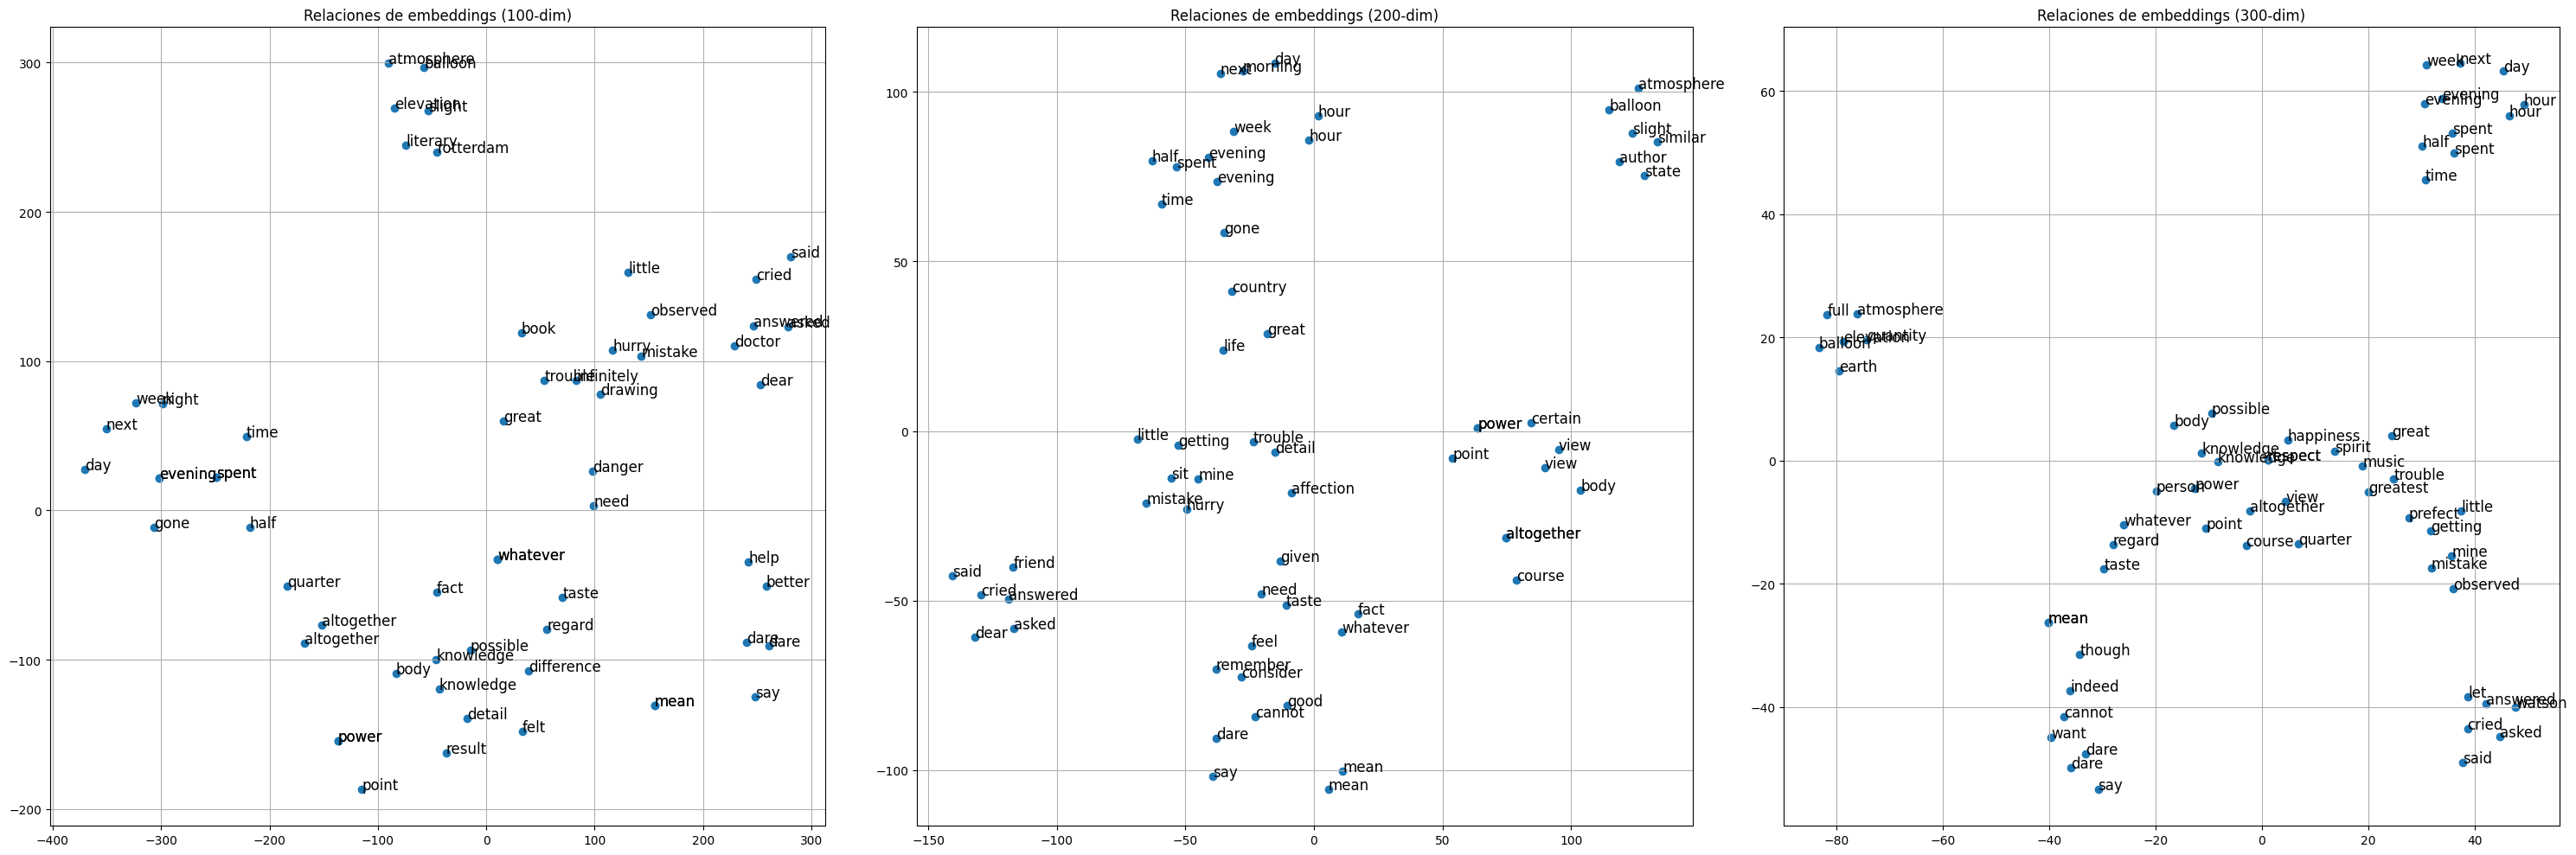

In [30]:
books_directory = 'books'
author = "edgar_allan_poe"
book = "the_works_of_edgard_allan_poe_volume_1.txt"
preprocessed_book = load_and_preprocess_book(books_directory, author, book)
top_keywords = extract_top_keywords_from_book(preprocessed_book, num_keywords=10)
print(f"Palabras clave: {top_keywords}")
plot_keywords_relationships(models, top_keywords)

Palabras clave: ['said', 'eye', 'long', 'man', 'thing', 'thought', 'say', 'length', 'matter', 'little']


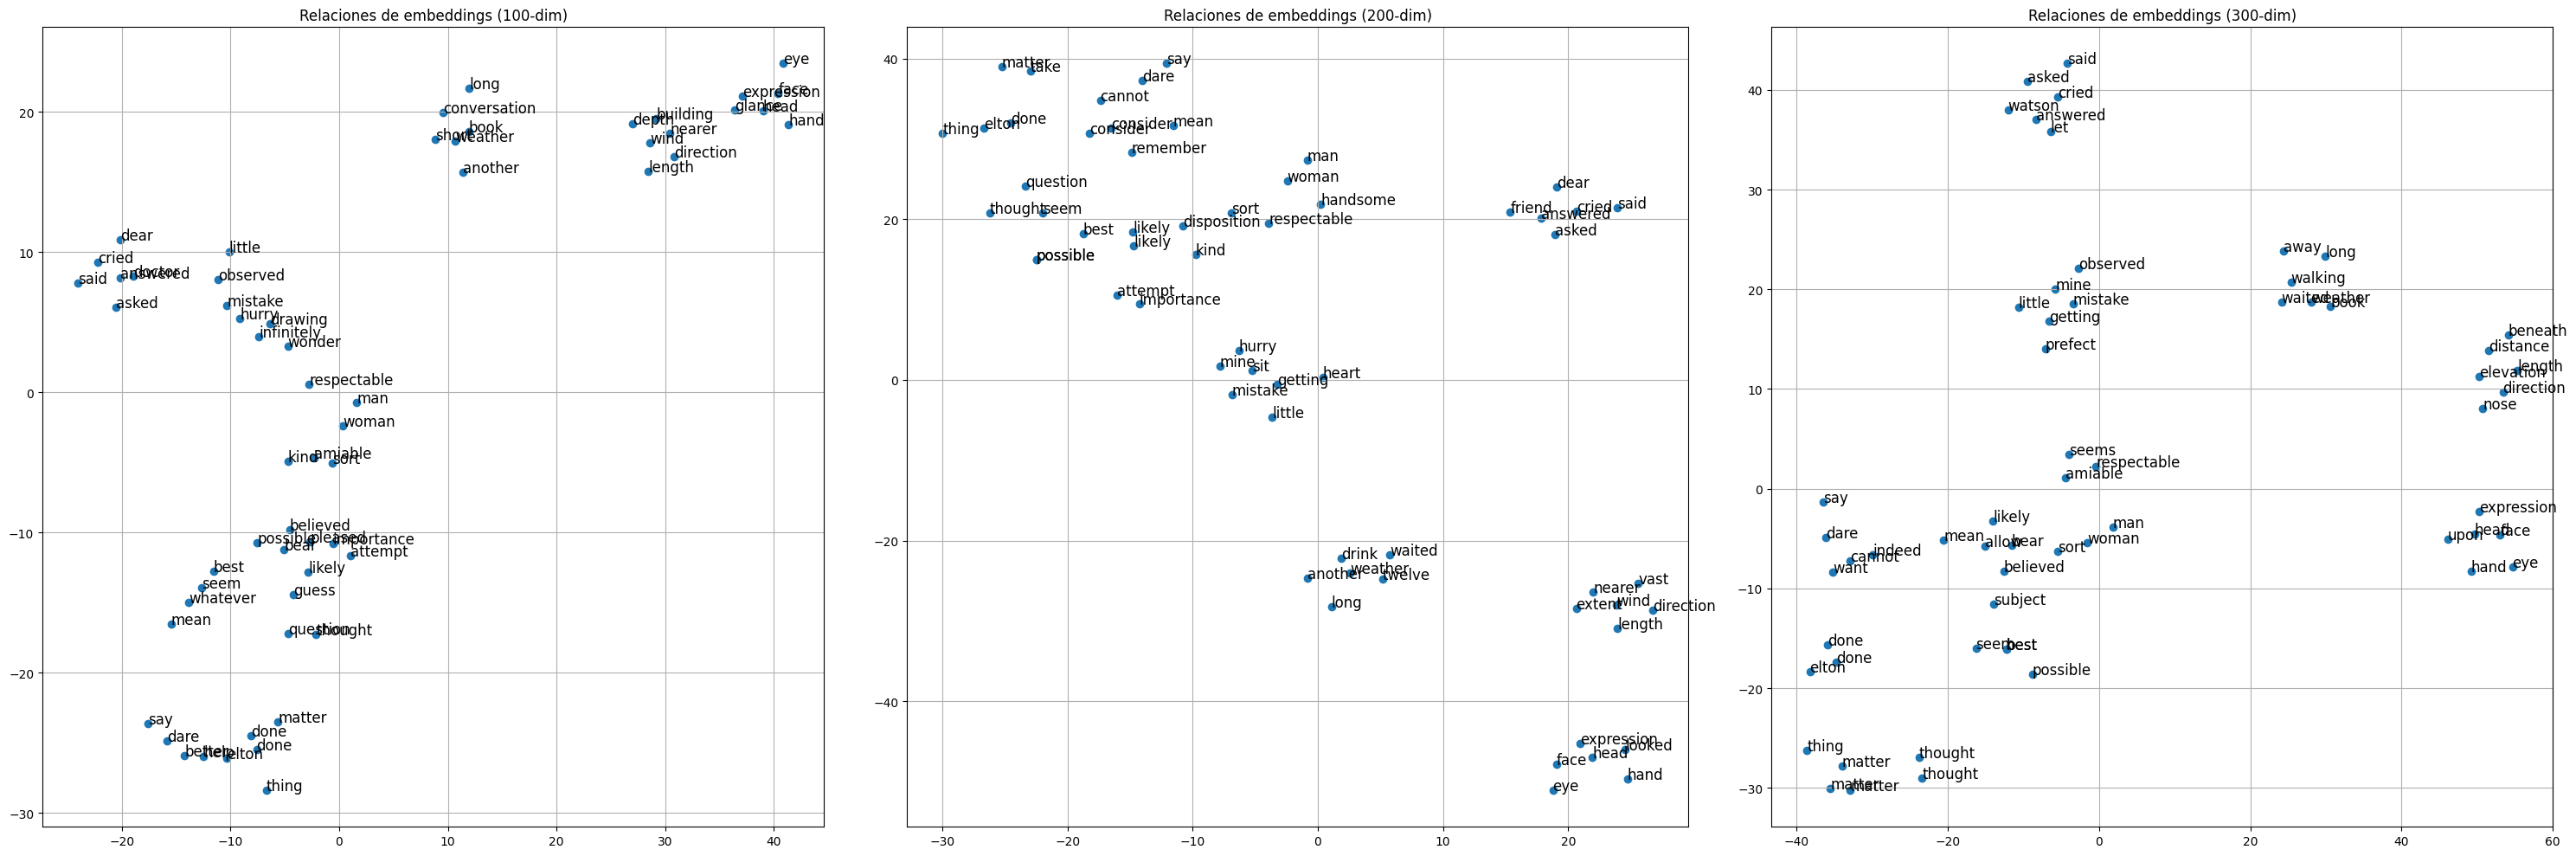

In [31]:
books_directory = 'books'
author = "edgar_allan_poe"
book = "the_works_of_edgard_allan_poe_volume_2.txt"
preprocessed_book = load_and_preprocess_book(books_directory, author, book)
top_keywords = extract_top_keywords_from_book(preprocessed_book, num_keywords=10)
print(f"Palabras clave: {top_keywords}")
plot_keywords_relationships(models, top_keywords)